In [131]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle

In [132]:
label_ptrange = [500, 600, 800, 1000, 1200, 1500, 2000]
label_leadingtype = ["LeadingJet", "SubJet"]
label_etaregion = ["Forward", "Central"]
label_jettype = ["Quark", "Gluon", "B_Quark", "C_Quark", "Other"]
# label_jettype = ["Data"]
label_var = ["pt", "eta", "ntrk", "width", "c1", "bdt"]
n_bins_var = [60, 50, 60, 60, 60, 60]

In [133]:
# newfile_path = input_path  / f"dijet_data_NEW_{period}{slice}.root"
period = "D"
slice = 5
newfile_path = f"/global/cfs/projectdirs/atlas/hrzhao/qgcal/Run_OldCodes/dijet_pythia_cut_{slice}-d.root"
# newfile_path = f"/global/cfs/projectdirs/atlas/hrzhao/qgcal/New_Codes/Validation/CheckMC16D_JZ{slice}/dijet_pythia_OLD_MC16D_JZ{slice}.root"

newfile = uproot.open(newfile_path)

# oldfile_path = input_path  / f"dijet_data_OLD_{period}{slice}.root"
oldfile_path =  f"/global/cfs/projectdirs/atlas/hrzhao/qgcal/dijet-mono-result/pythia/dijet_pythia_cut_{slice}-d.root"
oldfile = uproot.open(oldfile_path)

In [134]:
def Read_Histogram_by_JetType(file, code_version="new"):
    Read_HistMap = {}
    Read_HistMap_Error = {}

    if code_version=="new":
        file = file["NoReweighting"]

    available_keys = [*file.keys()]
    for i, jettype in enumerate(label_jettype):
        Read_HistMap[jettype] = np.zeros((n_bins_var[0]), dtype=float)
        Read_HistMap_Error[jettype] = np.zeros((n_bins_var[0]), dtype=float)
        for pt in label_ptrange[:-1]:
            for leadingtype in label_leadingtype[0:1]:
                for eta_region in label_etaregion: 
                    if not f"{pt}_{leadingtype}_{eta_region}_{jettype}_{label_var[0]};1" in available_keys:
                        continue 
                    Read_HistMap[jettype] += file[f"{pt}_{leadingtype}_{eta_region}_{jettype}_{label_var[0]}"].to_numpy()[0]
                    Read_HistMap_Error[jettype] += file[f"{pt}_{leadingtype}_{eta_region}_{jettype}_{label_var[0]}_err"].to_numpy()[0]

    return Read_HistMap, Read_HistMap_Error

In [135]:
Read_HistMap_newfile, Read_HistMap_Error_newfile = Read_Histogram_by_JetType(newfile, code_version="old")
Read_HistMap_oldfile, Read_HistMap_Error_oldfile = Read_Histogram_by_JetType(oldfile, code_version="old")

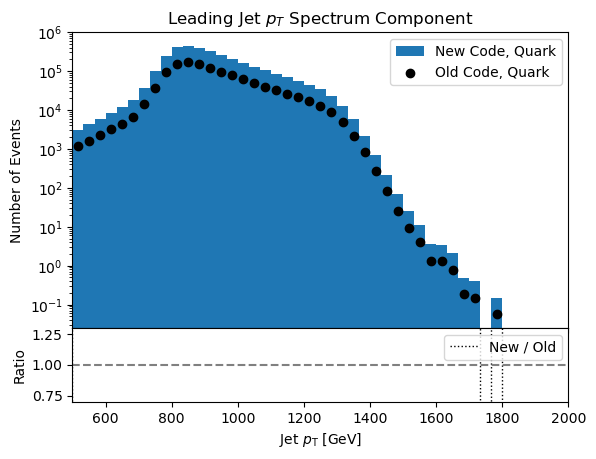

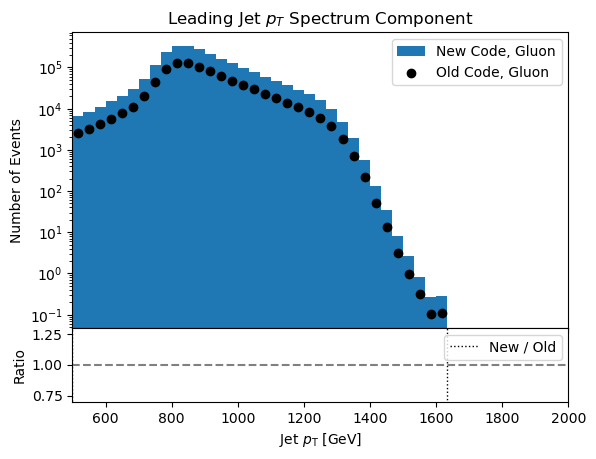

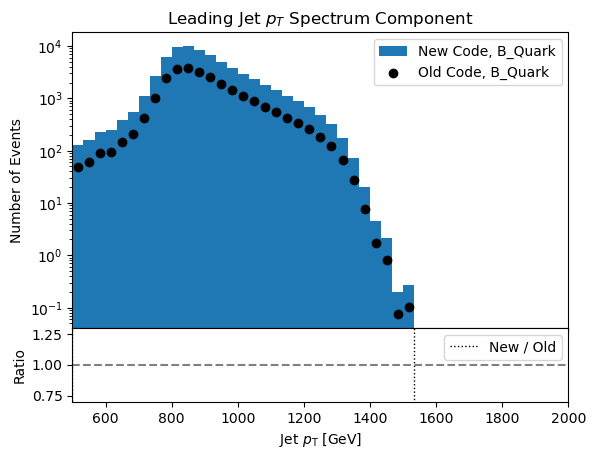

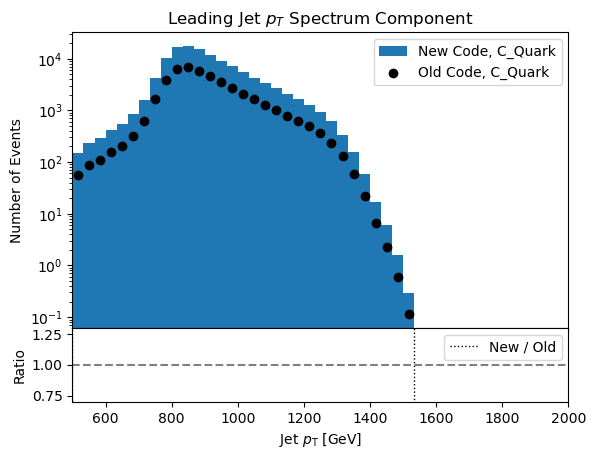

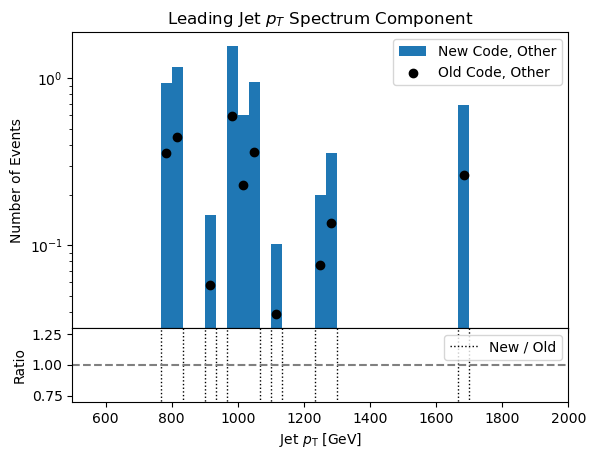

In [136]:
custom_bins = np.linspace(0, 2000, 61)
pt_bin_centers = 1/2 * (custom_bins[:-1] + custom_bins[1:])
for i, jettype in enumerate(label_jettype):
    fig, (ax, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    ax.fill_between(pt_bin_centers, 0, Read_HistMap_newfile[jettype], label=f"New Code, {jettype}", step = 'mid')
    ax.scatter(pt_bin_centers, Read_HistMap_oldfile[jettype], color= "black", marker= "o", label = f"Old Code, {jettype}")

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.true_divide(Read_HistMap_newfile[jettype], Read_HistMap_oldfile[jettype])
        ratio[ratio == np.inf] = 0
        ratio = np.nan_to_num(ratio)

    ax1.stairs(values = ratio, edges=custom_bins, color = "black", linestyle=':', label = 'New / Old', baseline=None)
    ax1.hlines(y = 1, xmin = 500, xmax = 2000, color = 'gray', linestyle = '--')
    ax1.set_ylabel("Ratio")
    ax1.set_ylim(0.7, 1.3)
    ax1.set_xlabel('Jet $p_{\mathrm{T}}$ [GeV]')
    
    ax.set_yscale('log')
    ax.set_xlim(500, 2000)
    # ax.set_title( f'MC16{period} {slice } ' + 'Leading Jet $p_{T}$ Spectrum Component')
    # ax.set_title( f'MC16A JZ8 ' + 'Leading Jet $p_{T}$ Spectrum Component')
    ax.set_title( 'Leading Jet $p_{T}$ Spectrum Component')

    ax.set_ylabel('Number of Events')
    ax.legend()
    ax1.legend()

    # assert np.sum(ratio[ratio!=0]) == len(ratio[ratio!=0])
    is_passed = np.allclose(Read_HistMap_newfile[jettype],  Read_HistMap_oldfile[jettype], rtol=1e-4)
    if is_passed:
        ax.annotate("Passed!", xy=(0, 1), xytext=(-15, -15), fontsize=10, color= 'red',
                    xycoords='axes fraction', textcoords='offset points',
                    bbox=dict(facecolor='white', alpha=0.8),
                    horizontalalignment='right', verticalalignment='top')

    fig.show()

In [137]:
def cal_sum(Read_HistMap):
    MC_jet_types = ['C_Quark', 'B_Quark', 'Gluon', 'Quark']
    MC_jets = []
    for MC_jet_type in MC_jet_types:
        MC_jets.append(Read_HistMap[MC_jet_type])

    MC_jets = np.array(MC_jets)
    cumsum_MC_jets = np.cumsum(MC_jets, axis = 0)
    return cumsum_MC_jets[-1], np.sum(MC_jets, axis = 1)

In [138]:
sum_new, sum_MC_jets_new = cal_sum(Read_HistMap=Read_HistMap_newfile)
sum_old, sum_MC_jets_old = cal_sum(Read_HistMap=Read_HistMap_oldfile)


In [139]:
sum_MC_jets_new

array([ 119516.13066221,   67766.49668599, 2361466.83263861,
       3196894.1927922 ])

In [140]:
def plot_compare(new_Read_HistMap, old_Read_HistMap, jettype, period, slice, if_save=False, output_path=None):
    fig, (ax, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    ax.fill_between(pt_bin_centers, 0, new_Read_HistMap, label=f"New NTuple, {jettype}, num:{np.sum(new_Read_HistMap):.2f}", step = 'mid')
    ax.scatter(pt_bin_centers, old_Read_HistMap, color= "black", marker= "o", label = f"Old NTuple, {jettype}, num:{np.sum(old_Read_HistMap):.2f}")

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.true_divide(new_Read_HistMap, old_Read_HistMap)
        ratio[ratio == np.inf] = 0
        ratio = np.nan_to_num(ratio)

    ax1.stairs(values = ratio, edges=custom_bins, color = "black", linestyle=':', label = 'New / Old', baseline=None)
    ax1.hlines(y = 1, xmin = 500, xmax = 2000, color = 'gray', linestyle = '--')
    ax1.set_ylabel("Ratio")
    # ax1.set_ylim(0.7, 1.3)
    ax1.set_xlabel('Jet $p_{\mathrm{T}}$ [GeV]')

    ax.set_yscale('log')
    ax.set_xlim(500, 2000)
    ax.set_title( f'MC16{period} {slice} ' + 'Leading Jet $p_{T}$ Spectrum Component')
    # ax.set_title( f'MC16A JZ8 ' + 'Leading Jet $p_{T}$ Spectrum Component')

    ax.set_ylabel('Number of Events')
    ax.legend()
    ax1.legend()

    # assert np.sum(ratio[ratio!=0]) == len(ratio[ratio!=0])
    is_passed = np.allclose(new_Read_HistMap,  old_Read_HistMap, rtol=1e-4)
    if is_passed:
        ax.annotate("Passed!", xy=(0, 1), xytext=(-15, -15), fontsize=10, color= 'red',
                    xycoords='axes fraction', textcoords='offset points',
                    bbox=dict(facecolor='white', alpha=0.8),
                    horizontalalignment='right', verticalalignment='top')

    if if_save == True:
        fig.savefig(output_path.as_posix() + "/" + f"pt_spectrum_compared_MC16{period}_JZ{slice}_{jettype}", dpi = 100)
    else:
        fig.show()

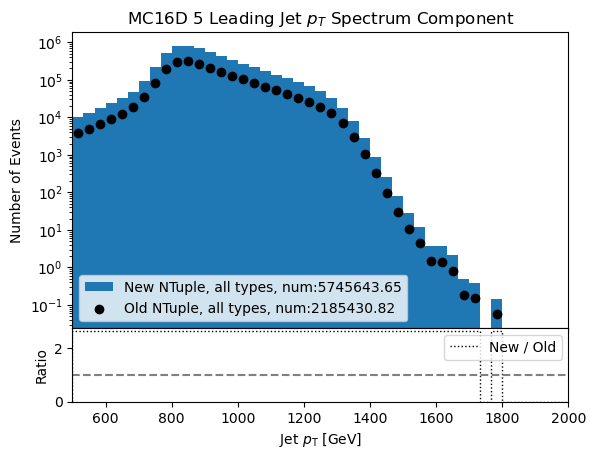

In [141]:
plot_compare(new_Read_HistMap=sum_new, old_Read_HistMap=sum_old, jettype='all types', period= period, slice =slice)

In [142]:
np.abs(Read_HistMap_newfile[label_jettype[0]] -  Read_HistMap_oldfile[label_jettype[0]])

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.89945159e+03,
       2.66892337e+03, 3.68850529e+03, 5.18761920e+03, 7.27034139e+03,
       1.10033768e+04, 2.30338181e+04, 6.05796062e+04, 1.51567637e+05,
       2.51392613e+05, 2.80130425e+05, 2.45725377e+05, 1.99272872e+05,
       1.57770098e+05, 1.26097363e+05, 1.00704996e+05, 8.09518264e+04,
       6.53159195e+04, 5.27801855e+04, 4.27824139e+04, 3.47374627e+04,
       2.76483212e+04, 2.09387234e+04, 1.41808988e+04, 7.98133881e+03,
       3.60228077e+03, 1.35428583e+03, 4.41173329e+02, 1.34705239e+02,
       4.26501895e+01, 1.54859160e+01, 6.69992955e+00, 2.19407226e+00,
       2.09678684e+00, 1.29641218e+00, 2.97295319e-01, 2.45241910e-01,
       0.00000000e+00, 9.16506286e-02, 0.00000000e+00, 0.00000000e+00,
      

In [143]:
Read_HistMap_newfile[label_jettype[0]] / Read_HistMap_oldfile[label_jettype[0]]

/tmp/ipykernel_34498/2910059077.py:1: RuntimeWarning: invalid value encountered in divide
  Read_HistMap_newfile[label_jettype[0]] / Read_HistMap_oldfile[label_jettype[0]]


array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       2.62906682, 2.62906682, 2.62906682, 2.62906682, 2.62906682,
       2.62906682, 2.62906682, 2.62906682, 2.62906682, 2.62906682,
       2.62906682, 2.62906682, 2.62906682, 2.62906682, 2.62906682,
       2.62906682, 2.62906682, 2.62906682, 2.62906682, 2.62906682,
       2.62906682, 2.62906682, 2.62906682, 2.62906682, 2.62906682,
       2.62906682, 2.62906682, 2.62906682, 2.62906682, 2.62906682,
       2.62906682, 2.62906682, 2.62906682, 2.62906682, 2.62906682,
       2.62906682, 2.62906682,        nan, 2.62906682,        nan,
              nan,        nan,        nan,        nan,        nan])